# Python for Creating CSV and Preliminary Reporting

In [1]:
import csv
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point


import geoviews as gv
import geoviews.feature as gf
import holoviews as hv

%matplotlib inline
plt.style.use('ggplot')

from datetime import date
print("Last run: ", date.today())

Last run:  2021-05-07


## Load Data and Write to CSV


In [3]:
with open("roman-amphitheaters.geojson") as f:
    j = json.load(f)

In [4]:
# If there is one, I'd welcome a more pythonic approach. One that 
# accomodates the variable data model supported by JSON.

d = []
for feature in j['features']:
    
    # Check for optional properties

    if 'latintoponym' in feature['properties'].keys():
        latintoponym = feature['properties']['latintoponym']
    else:
        latintoponym = ''    

    if 'welchid' in feature['properties'].keys():
        welchid = feature['properties']['welchid']
    else:
        welchid = ''

    if 'golvinid' in feature['properties'].keys():
        golvinid = feature['properties']['golvinid']
    else:
        golvinid = ''

    if 'buildingtype' in feature['properties'].keys():
        buildingtype = feature['properties']['buildingtype']
    else:
        buildingtype = ''
        
    try:
        zotero = feature['properties']['bibliography'][0]['zoteroitem']
    except:
        zotero = ''
 
    if 'chronogroup' in feature['properties'].keys():
        chronogroup = feature['properties']['chronogroup']
    else:
        chronogroup = ''

    secondcentury = True
    if 'exclude' in feature['properties'].keys():
        secondcentury = False

    if 'capacity' in feature['properties'].keys():
        capacity = feature['properties']['capacity']['quantity']
    else:
        capacity = ''

    if 'province' in feature['properties'].keys():
        romanregion = feature['properties']['province']
    elif 'region' in feature['properties'].keys():
        romanregion = feature['properties']['region']
    else:
        romanregion = ''
        
    arenamajor = ''
    arenaminor = ''
    extmajor = ''
    extminor = ''
    exteriorheight = ''
    if 'dimensions' in feature['properties'].keys():
        dimensions = feature['properties']['dimensions']
        
        if 'arenamajor' in dimensions.keys():
            arenamajor = dimensions['arenamajor']

        if 'arenaminor' in dimensions.keys():
            arenaminor = dimensions['arenaminor']
            
        if 'exteriormajor' in dimensions.keys():
            extmajor = dimensions['exteriormajor']

        if 'exteriorminor' in dimensions.keys():
            extminor = dimensions['exteriorminor']
            
        if 'exteriorheight' in dimensions.keys():
            exteriorheight = dimensions['exteriorheight']
            
    d.append((feature['id'],
              feature['properties']['title'],
              feature['properties']['label'],
              latintoponym,
              feature['properties']['pleiades'],
              welchid,
              golvinid,
              buildingtype,
              chronogroup,
              secondcentury,
              capacity,
              feature['properties']['moderncountry'],
              romanregion,
              zotero,
              arenamajor,
              arenaminor,
              extmajor,
              extminor,
              exteriorheight,
              feature['geometry']['coordinates'][0],
              feature['geometry']['coordinates'][1],
              feature['geometry']['coordinates'][2]))

ramphs_df = pd.DataFrame(d, columns=(
 'id',    # short id
 'title', # longer title
 'label', # short label
 'latintoponym', # latin toponym
 'pleiades', # pleiades https uri
 'welchid',  # id in Welch
 'golvinid', # id in Golvin
 'buildingtype',  # usually 'amphitheater'
 'chronogroup',   # label for the chronological group
 'secondcentury', # is this an amphitheater that was in use in 2nd century
 'capacity',    # capacity as integer
 'modcountry',  # modern country
 'romanregion', # province or augustan region of italy
 'zotero',      # zotero item id
 'arenamajor', # long axis of arena in meters
 'arenaminor', # short axis of arena in meters
 'extmajor',   # long axis of exterior
 'extminor', # short axis of exterior
 'exteriorheight',   # height of exterior wall if known
 'longitude', # latitude
 'latitude', # longitude
 'elevation'  # elevation in meters.
 )) 

ramphs_df[['capacity','elevation','arenamajor','arenaminor',
        'extmajor','extminor','exteriorheight']] = ramphs_df[['capacity','elevation','arenamajor',
        'arenaminor','extmajor','extminor','exteriorheight']].apply(pd.to_numeric)

In [5]:
ramphs_df.to_csv("roman-amphitheaters.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

In [ ]:
ramphs_df[['id','title','chronogroup','latintoponym','romanregion','modcountry','capacity',
           'extmajor','extminor','arenamajor','arenaminor','latitude','longitude']].to_csv('tmp.csv', index = False, quoting = csv.QUOTE_NONNUMERIC)

## Basic Reporting

In [ ]:
ramphs_df.head(2)

In [ ]:
ramphs_df.describe()

In [ ]:
ramphs_df[ramphs_df.secondcentury].describe()

In [ ]:
# Confirm that CSV is readable
# It would be nice if the "numeric pattern" string survived as strings.
pd.read_csv("roman-amphitheaters.csv", quoting = 2).describe()

In [ ]:
# which have heights
ramphs_df[ramphs_df.exteriorheight > 0]

In [ ]:
# which don't have exteriormajor
ramphs_df[pd.isnull(ramphs_df.extmajor)].sort_values(by = 'longitude')\
[['id','modcountry','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

In [ ]:
ramphs_df[ramphs_df.golvinid == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

In [ ]:
ramphs_df[ramphs_df.latintoponym == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

## Duplicate Checking

In [ ]:
dups = ramphs_df[ramphs_df.label.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

In [ ]:
dups = ramphs_df[ramphs_df.id.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

In [ ]:
dups = ramphs_df[ramphs_df.pleiades.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 15

In [ ]:
dups = ramphs_df[ramphs_df.latintoponym.duplicated(keep = False)]\
[['id','pleiades','latintoponym',
  'latitude','longitude']].sort_values('pleiades')

len(dups.query("latintoponym != ''")) == 11

## Basic Mapping

NOT WORKING RIGHT NOW AS I CONTEMPLATE MOVING FULL TO GeoViews.... 

In [19]:
rgdf = gpd.read_file("roman-amphitheaters.geojson")

ramphs_points_gv = gv.Points(rgdf, ['latitude', 'longitude'])
tiles = gv.tile_sources.EsriTerrain

current_map = (tiles * ramphs_points_gv.opts(  color='black', size=5) ).opts(width=1600, height=1200, toolbar=None)
#gv.save(current_map, "ramphs_2nd_century.png")
#!convert  ramphs_2nd_century.png  -colorspace Gray  fig01-heath.tif
current_map

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [latitude,longitude]

In [6]:
rgdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

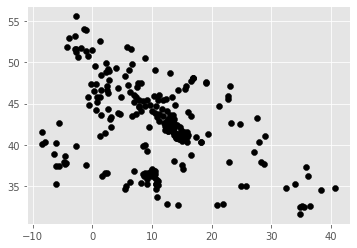

In [7]:
rgdf.plot(color = 'black')

In [ ]:
# this is simple enough that all steps are in one cell
c = []
for cgrp in j['romanamphitheaterschronogroups']:
    c.append((cgrp['id'],
    cgrp['startdate'],
    cgrp['enddate']))
    
chrono_df  = pd.DataFrame(c, columns=('chronogroup','startdate','enddate'))

chrono_df.to_csv("chronogrps.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)
chrono_df.head(2)

In [ ]:
ramphs_df.merge(chrono_df)